In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la
import scipy.integrate as sciint
from itertools import product
from functools import partial

import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential, ssn_power_law
from wilson_cowan_2d.analysis import nulclines as nuc
from wilson_cowan_2d.analysis import stability as sta
from wilson_cowan_2d.utils import make_counter

# Jupyter Specific
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


# Data path
data_path = "../data/"
analysis_fldr = "SSN_Stability_Analysis"
data_save_path = os.path.join(data_path, analysis_fldr)
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path)


from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [2]:
report_path = "/home/nicolasjudd/school_notes/neural/final_report/"
img_path = os.path.join(report_path, 'img')

### Fixed Point Analysis

In [3]:
# Data path
import os

data_p = "data"
analysis_fldr = "SSN_2D_Simulations"
data_save_path = os.path.join(data_p, analysis_fldr)
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path)

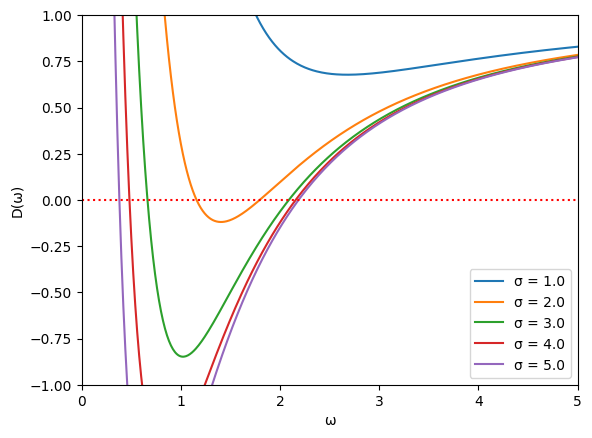

In [2545]:
fig = plt.figure()
ax = plt.gca()

# n = 2.1
# k = 0.8

τ = 0.6
τe = 1
τi = τ * τe
σe = 1
σi = 1 * σe



# A = np.array(( [1.1, 0.25]
#               ,[1, 0.11]))
# Θ = np.array([-0.25, -0.1])
n = 3
k = 0.8

A=np.array([[1, 1.5], [1, 0.25]])
Θ=np.array([0.001, 1.8])

u_bar, v_bar = np.array([3.157974  , 1.05103129])  #array([ 6.257137  , 17.87935319])  #.array([1.870343  , 5.31787505])  # array([6.102394  , 7.20120047])

# u_bar, v_bar = (np.array(0.65050003), np.array(5.148322))

param = wcp.SSNDefaultParams(τ = np.array([τe, τi]), n=n, k=k,
                             size = 1, σ = np.array([σe, σi])
                            ,A=A, Θ=Θ)

rang = np.linspace(0,100, 10_000)
dw_test = sta.calc_Dω_range(param, (u_bar, v_bar),
                            1, np.linspace(1,5,5),
                            point_range=rang, derv=sta.derv_SSNF)

_ = [plt.plot(rang, dw[0], label=f"σ = {dw[1]}") for dw in dw_test]
_ = plt.legend()
_ = plt.xlim(0, 5)
_ = plt.ylim(-1, 1)
_ = plt.hlines(0,0,1_000, color='r', linestyle=":")
_ = plt.ylabel("D(ω)")
_ = plt.xlabel("ω")

# plt.savefig(os.path.join(data_save_path, "new_linear_stability_analysis.png"))

In [2213]:
print(os.path.abspath(os.path.join(data_save_path)))

/home/nicolasjudd/school_notes/neural/py_projs/2D_wilson_cowan/notebooks/New Works/data/SSN_2D_Simulations


In [2355]:
b  =sta.calc_bs(param, u_bar, v_bar, derv=sta.derv_SSNF)

(1 + b[1,1])/(b[0,0] - 1)

0.2645464634631207

### Periodic Oribit Analysis

In [2310]:
past_period =0.6

In [2311]:
# To hold the time constant outputs
τ_output = list()
τ_err_list = list()

for ix, τ in enumerate(np.arange(0.2, 0.45, 0.01)):


    τe = 1
    σe = 1
    σi = 1 * σe
    
#     n = 3
#     k = 2
    
    # A = np.array(( [1.1, 0.25]
    #               ,[1, 0.11]))
    # Θ = np.array([-0.25, -0.1])
    
    n = 3
    k = 0.8

    A=np.array([[1, 1.5], [1, 0.25]])
    Θ=np.array([0.001, 1.8])
    
    
    param = wcp.SSNDefaultParams(τ = np.array([τe, τe*τ]).reshape(2,1)
                                 , size = 1, n=n, k=k , A=A, Θ=Θ)

    inp = np.array((u_bar, v_bar))  # np.array([0.68639287, 5.14749899])  # .reshape(2,1)

    # Find a point in the periodic orbid
    test = wck.WCUnif(inp, param)
    end = 100
    ures = test((0, end), t_eval=np.arange(0, end, 0.1)) 
    uv_init = ures._solved.y.T[-1].reshape(2,1)

    # Find Period
    def find_period_func(T):
        start = wck.WCUnif(uv_init, param)
        res = start((0,T),simple=True, t_eval=(0,T))
        return la.norm(uv_init - res.y.T[-1].reshape(2,1)) # , res

    period = opt.fsolve(find_period_func, past_period)[0]
    i = 1
    while(i < 100 and (period < 0.001 or period > (past_period + 0.75))):
        retry = past_period + 0.01*i
        period = opt.fsolve(find_period_func, retry)[0]
        i+=1
    if i >= 100:
        print(f"{τ} didn't resolve. Final period: {period}")
        τ_err_list.append(τ)
        continue
        
    past_period = period
    test = wck.WCUnif(uv_init, param)
    new_res = test((0,period), simple=True)

    new_u, new_v = new_res.y
    τ_output.append((τ, period, uv_init, (new_u, new_v)))

    if ix % 10 == 0:
        clear_output(wait=True)
        print("On iter: ", ix, "τ: ", τ, "Period: ", period)
    # _=  plt.plot(new_u, new_v)

On iter:  20 τ:  0.4000000000000002 Period:  1.3788039574227486


#### Checking Periods of Orbits

In [2312]:
gen = iter(τ_output)

In [2339]:
τ, period, _, (new_u, new_v) = next(gen)

print("Period: ", period, "for τ: ", τ)
plt.plot(new_u, new_v)


StopIteration: 

### Stability Analysis of Periodic Orbits

In [2529]:
import multiprocessing as mp

In [2559]:
# τ, period, uv_init, _ = τ_output[20]
output = list()
ωs = np.round(np.arange(0.05, 5, 0.05), 3)
σs = np.round(np.arange(0.1, 1, 0.1), 8)  #array([ 6.257137  , 17.87935319])), 4)

full_params = list()
for ((τ, p, init, _), ω, σ) in product(τ_output, ωs, σs):
    # n = 3
    # k = 0.8

    τe = 1
    σe = 1
    # A = np.array(( [1.1, 0.25]
    #               ,[1, 0.11]))
    # Θ = np.array([-0.25, -0.1])
    
    n = 3
    k = 0.8

    A=np.array([[1, 1.5], [1, 0.25]])
    Θ=np.array([0.001, 1.8])
    
    
    param = wcp.SSNMondronomyParams(n=n, k=k
                                    ,τ=np.array([τe, τ]), σ = np.array([σe, σ])
                                    , ω=ω, size=1, A=A, Θ=Θ)
    inp = np.concatenate((np.eye(2).ravel(), init.ravel()))
    full_params.append((p, inp, param))

def f(fparam):
    period, inp, param = fparam

    res = wck.WCDecExpMondronomy(inp, param, derv=sta.derv_SSNF)((0, period))
    X = res.y[:4].T[-1].reshape(2,2)

    tr = np.trace(X)
    dt = la.det(X)

    # If any of these are below zero, there will be an instability
    Q1 = 1 - tr + dt
    Q2 = 1 + tr + dt
    Q3 = 1 - dt
    if np.round(param.ω, 2) == 0.05 and np.round(param.σ[1],8) == 0.1: print(np.round(param.τ[1], 3))
    return {"σ": param.σ[1], "τ":param.τ[1], "ω": param.ω
            , "Q1":Q1,"Q2":Q2,"Q3":Q3, }
    
output = list()
with mp.Pool(8) as pool:
    for t in pool.imap_unordered(f, iter(full_params)):
        output.append(t)
    
    

0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44


In [2560]:
len(output)

22275

In [2561]:
out = pd.DataFrame(output)
# output_saves[τ] = out
out.query("Q1 < 0 or Q2 < 0 or Q3 < 0").min(axis=0)

σ     0.100000
τ     0.350000
ω     0.050000
Q1   -0.359651
Q2   -4.580215
Q3   -0.061341
dtype: float64

In [2562]:
# with open(os.path.join(data_save_path, "oldparams_more_SSN_mondronomy_analysis.pkl"), 'wb') as w:
#     pkl.dump(out, w)

In [2563]:
# with open(os.path.join('..','..','data', 'SSN_Stability_Analysis', 'SSN_mondronomy_analysis.pkl'), 'rb') as r:
#     out = pkl.load(r)

In [2564]:
out


,σ,τ,ω,Q1,Q2,Q3
0,0.3,0.20,0.05,0.532977,1.662367,0.902328
1,0.4,0.20,0.05,0.533075,1.662347,0.902289
2,0.6,0.20,0.05,0.533357,1.662291,0.902176
3,0.5,0.20,0.05,0.533202,1.662322,0.902238
4,0.8,0.20,0.05,0.533755,1.662208,0.902018
...,...,...,...,...,...,...
22270,0.5,0.44,4.95,0.876860,1.123996,0.999572
22271,0.9,0.44,4.95,0.868745,1.132320,0.999467
22272,0.6,0.44,4.95,0.873739,1.127198,0.999531
22273,0.8,0.44,4.95,0.869690,1.131349,0.999481


In [2565]:
out.Q2.describe()

count    22275.000000
mean         1.268357
std          0.550982
min         -4.580215
25%          1.026331
50%          1.287855
75%          1.514835
max          4.099330
Name: Q2, dtype: float64

In [2566]:
gen = iter(out.τ.unique())

nan
nan


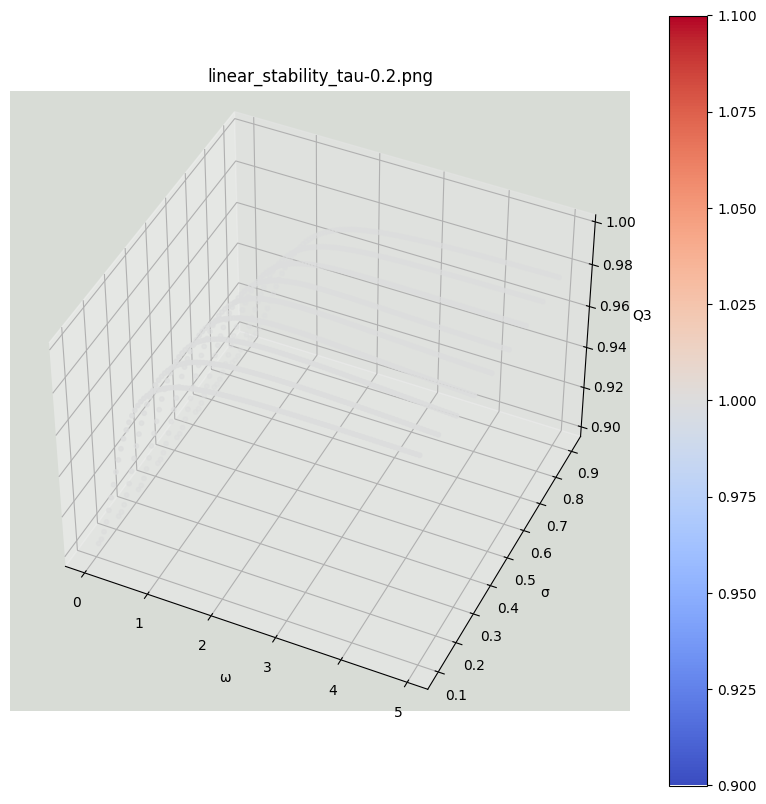

In [2567]:
Q = "Q3"

τemp = next(gen)
dat = out.loc[lambda x: x.τ == τemp]

fig_name = f"linear_stability_tau-{τemp}.png"
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

im = ax.scatter(dat.ω, dat.σ, np.sign(dat[Q])*(np.abs(dat[Q])), c=np.sign(dat[Q])
                , s=10, cmap=cm.coolwarm)

# im = ax.scatter(dat.ω, dat.σ, np.sign(dat[Q])*(np.abs(dat[Q])), s=10)

_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel(Q)
_ = ax.set_title(fig_name)

ax.set_facecolor('xkcd:light gray')
ax.view_init(42, -65)

print(dat.loc[lambda x: x[Q] < 0, 'σ'].min())
print(dat.loc[lambda x: x[Q] < 0, 'σ'].max())

τ = τemp
_ = plt.colorbar(im)

# plt.savefig(os.path.join(data_save_path, "periodic_orbit_stability_analysis.png"), bbox_inches='tight')

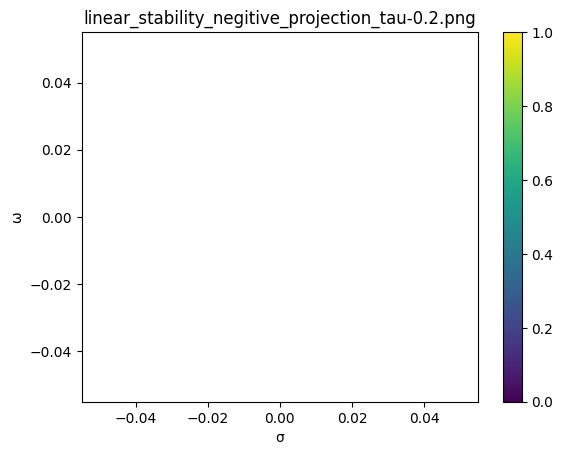

In [2568]:
fig_name = f"linear_stability_negitive_projection_tau-{τ}.png"
sdat = dat.loc[lambda x: x.Q3 <0][['ω', 'σ', 'Q2']]
_ = plt.scatter(sdat.σ, sdat.ω, s=20, cmap=cm.viridis, c=sdat.Q2)
_ = plt.xlabel("σ")
_ = plt.ylabel("ω")
_ = plt.title(fig_name)
_ = plt.colorbar()

# plt.facecolor('xkcd:light gray')

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

<Axes: xlabel='σ_min', ylabel='τ'>

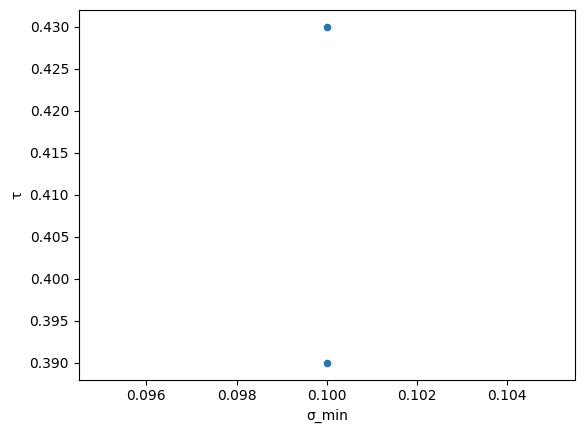

In [2569]:
out.loc[lambda x: x.Q1 < 0]\
.groupby("τ").agg(σ_min=('σ','min'), τ=('τ', 'unique')).plot(y='τ', x='σ_min', kind='scatter')

<Axes: xlabel='σ_min', ylabel='τ'>

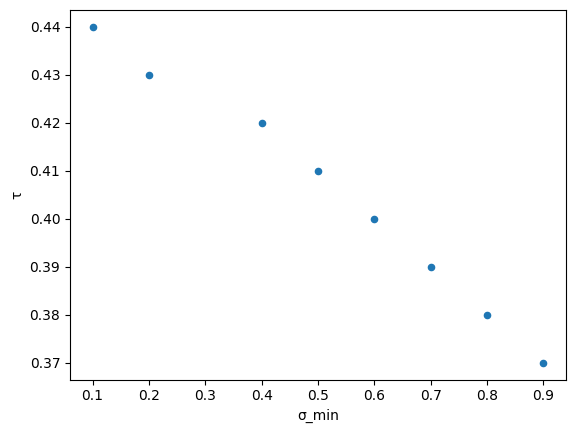

In [2570]:
out.loc[lambda x: x.Q2 < 0]\
.groupby("τ").agg(σ_min=('σ','min'), τ=('τ', 'unique')).plot(y='τ', x='σ_min', kind='scatter')

<Axes: xlabel='σ_min', ylabel='τ'>

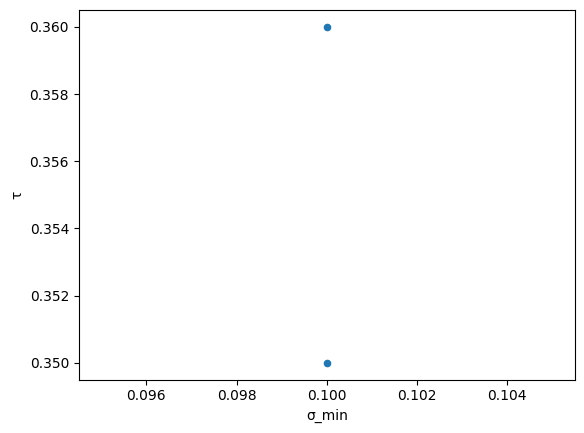

In [2571]:
out.loc[lambda x: x.Q3 < 0]\
.groupby("τ").agg(σ_min=('σ','min'), τ=('τ', 'unique')).plot(y='τ', x='σ_min', kind='scatter')

<Axes: xlabel='σ_min', ylabel='τ'>

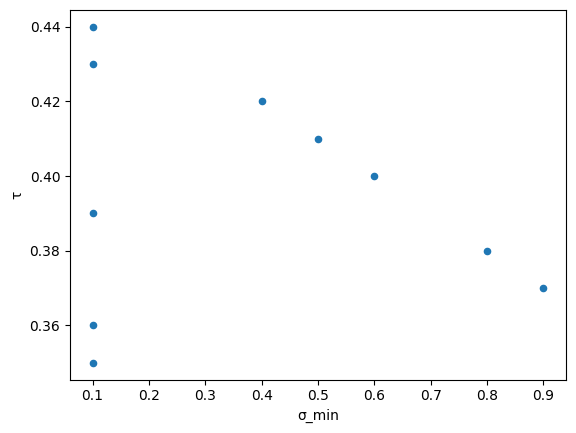

In [2573]:
out.loc[lambda x: (x.Q1 < 0) +(x.Q2 < 0)+(x.Q3 <0)]\
.groupby("τ").agg(σ_min=('σ','min'), τ=('τ', 'unique')).plot(y='τ', x='σ_min', kind='scatter')

In [2580]:
sig_mins = out.loc[lambda x: (x.Q1 < 0) +(x.Q2 < 0)+(x.Q3 <0)]\
.groupby("τ").agg(σ_min=('σ','min'), τ=('τ', 'unique'))

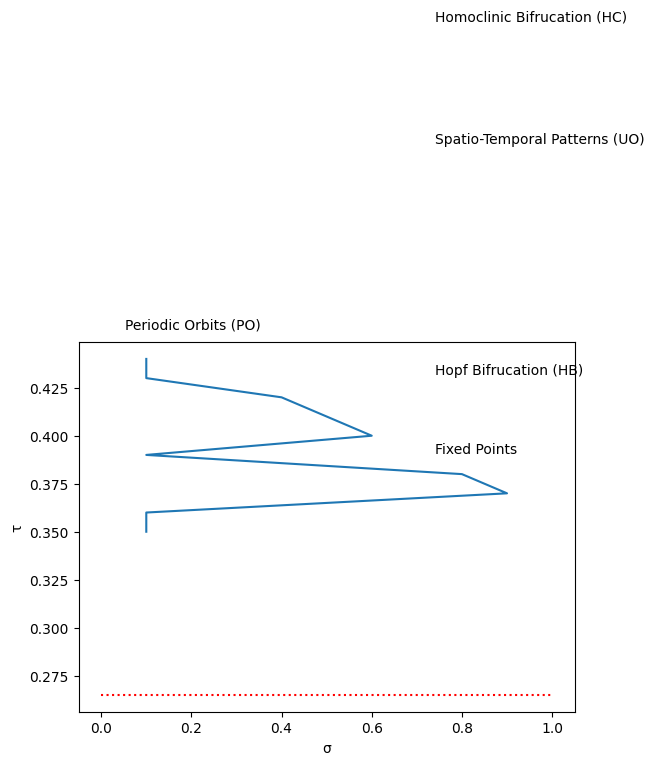

In [2581]:
_ = plt.plot('σ_min', 'τ', data = sig_mins)

_ = plt.xlabel("σ")
_ = plt.ylabel("τ")
_ = plt.hlines(0.265, xmin=0, xmax=1, linestyle = ":", color='r')


_ = plt.text(0.5, 0.2, f"Fixed Points",fontsize=10
             ,ha='left', va='bottom', transform=ax.transAxes)

_ = plt.text(0.0, 0.4, f"Periodic Orbits (PO)",fontsize=10
             ,ha='left', va='bottom', transform=ax.transAxes)

_ = plt.text(0.5, 0.7, f"Spatio-Temporal Patterns (UO)",fontsize=10
             ,ha='left', va='bottom', transform=ax.transAxes)

_ = plt.text(0.5, 0.92, f"Homoclinic Bifrucation (HC)",fontsize=10
             ,ha='left', va='top', transform=ax.transAxes)

_ = plt.text(0.5, 0.35, f"Hopf Bifrucation (HB)",fontsize=10
             ,ha='left', va='top', transform=ax.transAxes)
# plt.savefig(os.path.join(img_path, 'SSN_Stability_2d_periodic_orbits.png'))
# _ = plt.ylim(3.5,4.5)
# _ = plt.xlim(0,2)

In [2579]:
print(os.path.abspath(

SyntaxError: incomplete input (654282535.py, line 1)